Notebook by:

* Lorenzo Pannacci 1948926
* ADD YOUR NAME

## Startup

In [1]:
######################
# LIBRARIES DOWNLOAD #
######################

install_packages = False
if install_packages:
    %pip install numpy pandas pyspark

In [2]:
####################
# LIBRARIES IMPORT #
####################

import numpy as np
import pandas as pd
from pyspark import SparkContext
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

import os
# set spark environment
# os.environ['PYSPARK_PYTHON'] = r"D:\File\Anaconda\pythonw.exe"
# os.environ['PYSPARK_DRIVER_PYTHON'] = r"D:\File\Anaconda\pythonw.exe"

os.environ['PYSPARK_PYTHON'] = r"D:\Programs\Anaconda\pythonw.exe"
os.environ['PYSPARK_DRIVER_PYTHON'] = r"D:\Programs\Anaconda\pythonw.exe"

In [3]:
#####################
# GLOBAL PARAMETERS #
#####################

dataset_path = r"data/vodclickstream_uk_movies_03.csv"

## 1. Recommendation sytem 

Implementing a recommendation system is critical for businesses and digital platforms that want to thrive in today's competitive environment. These systems use data-driven personalization to tailor content, products, and services to individual user preferences. The latter improves user engagement, satisfaction, retention, and revenue through increased sales and cross-selling opportunities. In this section, you will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user. 

To be more specific, you will implement your version of the [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user. 

__Data__: The data you will be working with can be found [here](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies).

Looking at the data, you can see that there is data available for each user for the movies the user <ins>clicked on</ins>. Gather the __title and genre__ of the __maximum top 10 movies__ that each user clicked on regarding the __number of clicks__.

In [4]:
# TODO

### 1.2 Minhash Signatures

Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket. 

__Important note:__ You must write your minhash function from scratch.  You are not permitted to use any already implemented hash functions.  Read the class materials and, if necessary, conduct an internet search.  The description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf) may be helpful as a reference.

In [5]:
# TODO

### 1.3 Locality-Sensitive Hashing (LSH)

Now that your buckets are ready, it's time to ask a few queries. We will provide you with some user_ids and ask you to recommend at __most five movies__ to the user to watch based on the movies clicked by similar users. 

To recommend at most five movies given a user_id, use the following procedure: 

1. Identify the <ins>two most similar</ins> users to this user.
2. If these two users have any movies __in common__, recommend those movies based on the total number of clicks by these users.
3. If there are __no more common__ movies, try to propose the most clicked movies by the __most similar user first__, followed by the other user. 

__Note:__ At the end of the process, we expect to see at most five movies recommended to the user.

__Example:__ assume you've identified user __A__ and __B__ as the most similar users to a single user, and we have the following records on these users: 

- User A with 80% similarity
- User B with 50% similarity
  
|user|movie title|#clicks|
|---|---|---|
|A|Wild Child|20|
|A|Innocence|10|
|A|Coin Heist|2|
|B|Innocence|30|
|B|Coin Heist|15|
|B|Before I Fall|30|
|B|Beyond Skyline|8|
|B|The Amazing Spider-Man|5|

- __Recommended movies__ in order:
    - Innocence
    - Coin Heist
    - Wild Child
    - Before I Fall
    - Beyond Skyline

In [6]:
# TODO

## 2. Grouping Users together!

Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

### 2.1 Getting your data + feature engineering

1)  Access to the data found in [this dataset](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies)

2)  Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as *feature engineering*. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features **for each** user:

    a)  Favorite genre (i.e., the genre on which the user spent the most time)

    b)  Average click duration

    c)  Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

    d)  Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

    e)  Average time spent a day by the user (considering only the days he logs in)

So, in the end, you should have for each user_id five features.

3)  Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

---

We start by exploring our data and convert it in a more usable form. The dataset is light, we don't have to worry about dividing it into chunks.

---

In [7]:
# load the dataset from the .json file to a pandas dataframe
original_dataset = pd.read_csv(dataset_path)
original_dataset

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


In [8]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


---

The first thing we notice is the presence of a column called `Unnamed: 0` that has an incremental value. We can discard it and uses our index that starts from 0:

---

In [9]:
original_dataset.drop('Unnamed: 0', axis = 1, inplace = True)
original_dataset

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


---

It will be useful to convert both the the `datetime` and the `release_date` columns from a string to actual datetime format. We notice that some entries of `release_date` have value `NOT AVAILABLE`, we will have to convert them to NaT (Not a Time).

---

In [10]:
original_dataset.datetime = pd.to_datetime(original_dataset.datetime, errors='coerce')
original_dataset.release_date = pd.to_datetime(original_dataset.release_date, errors='coerce')
original_dataset

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


In [11]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      671736 non-null  datetime64[ns]
 1   duration      671736 non-null  float64       
 2   title         671736 non-null  object        
 3   genres        671736 non-null  object        
 4   release_date  641432 non-null  datetime64[ns]
 5   movie_id      671736 non-null  object        
 6   user_id       671736 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 35.9+ MB


---

The Kaggle page of the dataset (https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies) give us informations about the `duration` column:

`'duration' shows how long it was (in seconds) until that user clicked on another URL. A watch time of zero seconds means they visited the page but instantly clicked away.`

It is already a float, we don't need to treat it any further.

We can check the consistency of the dataset by checking if the same movie (i.e. all the entries with same `movie_id`) have the same characteristics (i.e. same `title`, `genres` and `release date`):

---

In [12]:
# iterate trough every movie
for movie_id, group_data in original_dataset.groupby('movie_id'):
    
    # check if there is more than a title for the same movie
    if group_data.title.unique().shape[0] != 1:
        print("Movie", movie_id, "has more than a title!")

    # check if there is more than a genre list for the same movie
    if group_data.genres.unique().shape[0] != 1:
        print("Movie", movie_id, "has conflicting genres!")

    # check if there is more than a release date for the same movie
    if group_data.release_date.unique().shape[0] != 1:
        print("Movie", movie_id, "has conflicting release dates!")

---

Since the `genres` column is a string we have to convert it to a list.

---

In [13]:
original_dataset.genres = original_dataset.genres.apply(lambda row: row.split(','))
original_dataset

,datetime,duration,title,genres,release_date,movie_id,user_id
0,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe
1,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510
2,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
4,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...
671731,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,[Talk-Show],2019-06-12,43cd23f30f,57501964fd
671732,2019-06-30 21:49:34,91157.0,HALO Legends,"[Animation, Action, Adventure, Family, Sci...",2010-02-16,febf42d55f,d4fcb079ba
671733,2019-06-30 22:00:44,0.0,Pacific Rim,"[Action, Adventure, Sci-Fi]",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"[Documentary, Music]",2019-02-08,52d49c515a,0b8163ea4b


---

We want to build a new dataset of user features extracted from the current one. We start by creating a dataframe containing only `user_id` and we populate it each time we build a new feature.

---

In [14]:
# empty user dataframe
users_dataset_base = pd.DataFrame(original_dataset.user_id.unique(), columns = ["user_id"])


'''
    The first feature we want to build is:
    **Favorite genre (i.e., the genre on which the user spent the most time)**
    We can exploit the `explode` method of Pandas to get from each entry a new entry for each genre in the list:
'''

# create exploded dataframe
exploded_dataset = original_dataset.explode("genres")[["user_id", "genres", "duration"]]

# add together all values with same user_id and same genre
exploded_dataset = exploded_dataset.groupby(["user_id", "genres"]).sum()

# get most watched genre
exploded_dataset = exploded_dataset.groupby("user_id").idxmax()
exploded_dataset.duration = exploded_dataset.duration.apply(lambda row: row[1])

# rename column
exploded_dataset = exploded_dataset.rename(columns={'duration': 'favorite_genre'})

# merge into user dataset
users_dataset_base = users_dataset_base.merge(exploded_dataset, left_on = "user_id", right_index = True)

'''
    The second feature to extract is:
    **Average click duration**
    This is very fast as we have just to calculate the mean of the `duration` columns of every user:
'''

# get mean
mean_dataset = original_dataset.groupby("user_id").duration.mean().reset_index()

# rename column
mean_dataset = mean_dataset.rename(columns={'duration': 'mean_duration'})

# merge into user dataset
users_dataset_base = users_dataset_base.merge(mean_dataset)

'''
    The third feature feature is:
    **Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)**

    We will use as delimitations between the three time parts:
    - Morning: 6 to 14
    - Afternoon: 14 to 20
    - Night: 20 to 6
'''

# create working dataframe substituting the whole datetime with hour
hours = original_dataset[["user_id", "datetime", "duration"]].copy()
hours.datetime = hours.datetime.dt.hour

# cluster hours into three time periods
hours.datetime = hours.datetime.apply(lambda x: 'morning' if 6 <= x < 14 else 'afternoon' if 14 <= x < 20 else 'night')

# get most active time period for each user
hours = hours.groupby(["user_id", "datetime"]).sum().groupby("user_id").idxmax()
hours.duration = hours.duration.apply(lambda row: row[1])

# rename column
hours = hours.rename(columns={'duration': 'favorite_time_day'})

# merge into user dataset
users_dataset_base = users_dataset_base.merge(hours, left_on = "user_id", right_index = True)

'''
    The fourth feature is:
    **Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?**
'''

# convert all datetimes to only the year 
years = original_dataset[["user_id", "release_date"]].copy()
years.release_date = years.release_date.dt.year

# check if film is old or not
years["new"] = years.release_date > 2010
years["old"] = years.release_date <= 2010

# count for each user how many have release year > 2010 and how many not, use boolean value as new column
user_oldnew = years.groupby("user_id").old.sum() > years.groupby("user_id").new.sum()

# rename column
user_oldnew.name = "is_oldmovies_lover"

# merge into user dataset
users_dataset_base = users_dataset_base.merge(user_oldnew, left_on = "user_id", right_index = True)

'''
    The fifth feature is:
    **Average time spent a day by the user (considering only the days he logs in)**
'''

# we can just take the mean_duration column and divide it by the number of different days the same user has in the dataset.

# we count how many different days every user has logged in
days = original_dataset[["user_id", "datetime"]].copy()
days["datetime"] = days["datetime"].dt.floor('D')
days = days.groupby("user_id").datetime.nunique()

# we count the total duration per user
sums = original_dataset.groupby("user_id").duration.sum()

# divide total duration by number of days
average_per_day = sums / days

# rename column
average_per_day.name = "duration_per_day"

# merge into user dataset
users_dataset_base = users_dataset_base.merge(average_per_day, left_on = "user_id", right_index = True)

In [15]:
users_dataset_base

,user_id,favorite_genre,mean_duration,favorite_time_day,is_oldmovies_lover,duration_per_day
0,1dea19f6fe,Drama,0.000000,night,True,0.000000
1,544dcbc510,Fantasy,1553.750000,afternoon,False,18645.000000
2,7cbcc791bf,Thriller,4218.666667,afternoon,False,8437.333333
3,ebf43c36b6,Action,1883.533333,afternoon,False,9417.666667
4,a57c992287,Drama,3684.538462,afternoon,False,7369.076923
...,...,...,...,...,...,...
161913,45414be0ec,Romance,0.000000,afternoon,False,0.000000
161914,783ec67e84,Drama,0.000000,afternoon,True,0.000000
161915,89c715f3a4,Adventure,-1.000000,afternoon,False,-1.000000
161916,9207e1499b,Crime,42592.000000,night,False,42592.000000


---

The additional features we propose are:

- `watchtime`: the total watchtime of a certain user. It's the sum of all the durations.
- `iterations`: the total number of iterations of a certain user. It's the number of rows related to that user.
- `active_days`: the number of days the user has been active on the site. 
- `n_movies`: the number of unique movies watched by the user
- `max_rewatches`: the maximum number of times the user has watched the same movie
- `favorite_day`: the user favourite day of the week to watch movies. We search it by finding the day with the highest duration overall for that user
- `favorite_month`: the user favourite month of the year to watch movies. We search it by finding the month with the highest duration overall for that user
- `most_active_year`: the year the user has been most active on based on the duration.
- `is_weekend_watcher`: if the user is a weekend watcher. We define a user "weekend watcher" if at least 50% of it's views are on saturday or sunday
- `longest_iteration`: the longest iteration registered for the user. We search it by finding the max across all durations

---

In [16]:
# create empty user dataframe
users_dataset_extended = pd.DataFrame(original_dataset.user_id.unique(), columns = ["user_id"])

# watchtime feature
n_movies = original_dataset.groupby("user_id").duration.sum()
n_movies.name = "total watchtime"

users_dataset_extended = users_dataset_extended.merge(n_movies, left_on = "user_id", right_index = True)

# number of iterations feature
n_iterations = original_dataset.groupby("user_id").size()
n_iterations.name = "iterations"

users_dataset_extended = users_dataset_extended.merge(n_iterations, left_on = "user_id", right_index = True)

# number of active days feature
days_active = original_dataset[["user_id", "datetime"]].copy()
days_active["datetime"] = days_active["datetime"].dt.floor('D')
days_active = days_active.groupby("user_id").datetime.nunique()
days_active.name = "active_days"

users_dataset_extended = users_dataset_extended.merge(days_active, left_on = "user_id", right_index = True)

# number of unique movies feature
n_movies = original_dataset.groupby("user_id").movie_id.nunique()
n_movies.name = "n_movies"
users_dataset_extended = users_dataset_extended.merge(n_movies, left_on = "user_id", right_index = True)

# highest number of rewatches feature
rewatch = original_dataset.groupby(["user_id", "movie_id"]).size().groupby("user_id").max()
rewatch.name = "max_rewatches"

users_dataset_extended = users_dataset_extended.merge(rewatch, left_on = "user_id", right_index = True)

# favorite day of the week feature
favourite_day = original_dataset[["user_id", "datetime"]].copy()
favourite_day.datetime = favourite_day.datetime.dt.dayofweek
favourite_day = favourite_day.groupby(["user_id", "datetime"]).size().groupby("user_id").idxmax().apply(lambda x: x[1])
favourite_day.name = "favorite_day"

users_dataset_extended = users_dataset_extended.merge(favourite_day, left_on = "user_id", right_index = True)

# favorite month of the year feature
favourite_month = original_dataset[["user_id", "datetime"]].copy()
favourite_month.datetime = favourite_month.datetime.dt.month
favourite_month = favourite_month.groupby(["user_id", "datetime"]).size().groupby("user_id").idxmax().apply(lambda x: x[1])
favourite_month.name = "favorite_month"

users_dataset_extended = users_dataset_extended.merge(favourite_month, left_on = "user_id", right_index = True)

# most active year feature
most_active_year = original_dataset[["user_id", "datetime"]].copy()
most_active_year.datetime = most_active_year.datetime.dt.year
most_active_year = most_active_year.groupby(["user_id", "datetime"]).size().groupby("user_id").idxmax().apply(lambda x: x[1])
most_active_year.name = "most_active_year"

users_dataset_extended = users_dataset_extended.merge(most_active_year, left_on = "user_id", right_index = True)

# weekend person feature
def weekend_function(row):
    row = row.droplevel(0)
    row = row.reindex(range(7), fill_value=0)
    return (row[5] + row[6]) > (row[0] + row[1] + row[2] + row[3] + row[4])

weekend = original_dataset[["user_id", "datetime"]].copy()
weekend.datetime = weekend.datetime.dt.dayofweek
weekend = weekend.groupby(["user_id", "datetime"]).size()
weekend = weekend.groupby("user_id").apply(weekend_function)
weekend.name = "is_weekend_user"

users_dataset_extended = users_dataset_extended.merge(weekend, left_on = "user_id", right_index = True)

# longest iteration feature
longest_iteration = original_dataset.groupby("user_id").duration.max()
longest_iteration.name = "longest_iteration"

users_dataset_extended = users_dataset_extended.merge(longest_iteration, left_on = "user_id", right_index = True)

In [17]:
users_dataset_extended

,user_id,total watchtime,iterations,active_days,n_movies,max_rewatches,favorite_day,favorite_month,most_active_year,is_weekend_user,longest_iteration
0,1dea19f6fe,0.0,1,1,1,1,6,1,2017,True,0.0
1,544dcbc510,18645.0,12,1,8,3,6,1,2017,True,10933.0
2,7cbcc791bf,25312.0,6,3,4,3,6,1,2017,False,10530.0
3,ebf43c36b6,28253.0,15,3,12,2,6,1,2017,True,7524.0
4,a57c992287,95798.0,26,13,22,3,0,1,2017,False,56338.0
...,...,...,...,...,...,...,...,...,...,...,...
161913,45414be0ec,0.0,1,1,1,1,6,6,2019,True,0.0
161914,783ec67e84,0.0,1,1,1,1,6,6,2019,True,0.0
161915,89c715f3a4,-1.0,1,1,1,1,6,6,2019,True,-1.0
161916,9207e1499b,42592.0,1,1,1,1,6,6,2019,True,42592.0


---

And finally we merge the two datasets.

---

In [18]:
users_dataset = users_dataset_base.merge(users_dataset_extended)
users_dataset

,user_id,favorite_genre,mean_duration,favorite_time_day,is_oldmovies_lover,duration_per_day,total watchtime,iterations,active_days,n_movies,max_rewatches,favorite_day,favorite_month,most_active_year,is_weekend_user,longest_iteration
0,1dea19f6fe,Drama,0.000000,night,True,0.000000,0.0,1,1,1,1,6,1,2017,True,0.0
1,544dcbc510,Fantasy,1553.750000,afternoon,False,18645.000000,18645.0,12,1,8,3,6,1,2017,True,10933.0
2,7cbcc791bf,Thriller,4218.666667,afternoon,False,8437.333333,25312.0,6,3,4,3,6,1,2017,False,10530.0
3,ebf43c36b6,Action,1883.533333,afternoon,False,9417.666667,28253.0,15,3,12,2,6,1,2017,True,7524.0
4,a57c992287,Drama,3684.538462,afternoon,False,7369.076923,95798.0,26,13,22,3,0,1,2017,False,56338.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,45414be0ec,Romance,0.000000,afternoon,False,0.000000,0.0,1,1,1,1,6,6,2019,True,0.0
161914,783ec67e84,Drama,0.000000,afternoon,True,0.000000,0.0,1,1,1,1,6,6,2019,True,0.0
161915,89c715f3a4,Adventure,-1.000000,afternoon,False,-1.000000,-1.0,1,1,1,1,6,6,2019,True,-1.0
161916,9207e1499b,Crime,42592.000000,night,False,42592.000000,42592.0,1,1,1,1,6,6,2019,True,42592.0


### 2.2 Choose your features (variables)!

You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1)  *To normalise or not to normalise? That's the question*. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the `scikit-learn` library).

2)  Select **one** method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

---

We will use as dimensionality reduction method the **Principal Component Analysis**. As the request make us choce only one dimensionality reduction method we will have to remove the two categorial features we have inside our dataset, `favorite_time_day` and `favorite_genre`.

---

In [19]:
users_dataset.drop(["favorite_genre", "favorite_time_day"], axis = 1, inplace = True)
users_dataset.set_index('user_id', inplace=True)
users_dataset

,mean_duration,is_oldmovies_lover,duration_per_day,total watchtime,iterations,active_days,n_movies,max_rewatches,favorite_day,favorite_month,most_active_year,is_weekend_user,longest_iteration
user_id,,,,,,,,,,,,,
1dea19f6fe,0.000000,True,0.000000,0.0,1,1,1,1,6,1,2017,True,0.0
544dcbc510,1553.750000,False,18645.000000,18645.0,12,1,8,3,6,1,2017,True,10933.0
7cbcc791bf,4218.666667,False,8437.333333,25312.0,6,3,4,3,6,1,2017,False,10530.0
ebf43c36b6,1883.533333,False,9417.666667,28253.0,15,3,12,2,6,1,2017,True,7524.0
a57c992287,3684.538462,False,7369.076923,95798.0,26,13,22,3,0,1,2017,False,56338.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45414be0ec,0.000000,False,0.000000,0.0,1,1,1,1,6,6,2019,True,0.0
783ec67e84,0.000000,True,0.000000,0.0,1,1,1,1,6,6,2019,True,0.0
89c715f3a4,-1.000000,False,-1.000000,-1.0,1,1,1,1,6,6,2019,True,-1.0


---

We  beleive that normalization is needed in our dataset because it makes the weight a certain feature has on the distance between points indipendent from the values that feature treats. If for  xample we have a certain arbitrary feature orders of magnitude greater than any other without normalization that would become the only significant component when calculating distance.

We decided to use the standardization as normalizing function, to every feature we subtract the mean and divide by the standard deviation. This normalization fuction is available as `sklearn.preprocessing.StandardScaler`.

---

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(users_dataset)
scaled_users_dataset = pd.DataFrame(scaled_data, columns = users_dataset.columns)
scaled_users_dataset

,mean_duration,is_oldmovies_lover,duration_per_day,total watchtime,iterations,active_days,n_movies,max_rewatches,favorite_day,favorite_month,most_active_year,is_weekend_user,longest_iteration
0,-0.262460,2.007893,-0.288760,-0.373700,-0.480402,-0.539466,-0.491091,-0.515130,1.412119,-1.462076,-1.171474,1.516133,-0.352242
1,-0.253090,-0.498034,-0.193209,-0.323529,1.197928,-0.539466,1.143182,0.998340,1.412119,-1.462076,-1.171474,1.516133,-0.315727
2,-0.237018,-0.498034,-0.245521,-0.305589,0.282475,0.171208,0.209312,0.998340,1.412119,-1.462076,-1.171474,-0.659573,-0.317073
3,-0.251101,-0.498034,-0.240497,-0.297676,1.655654,0.171208,2.077053,0.241605,1.412119,-1.462076,-1.171474,1.516133,-0.327113
4,-0.240239,-0.498034,-0.250995,-0.115924,3.333984,3.724579,4.411729,0.998340,-1.453497,-1.462076,-1.171474,-0.659573,-0.164079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,-0.262460,-0.498034,-0.288760,-0.373700,-0.480402,-0.539466,-0.491091,-0.515130,1.412119,0.017497,1.489264,1.516133,-0.352242
161914,-0.262460,2.007893,-0.288760,-0.373700,-0.480402,-0.539466,-0.491091,-0.515130,1.412119,0.017497,1.489264,1.516133,-0.352242
161915,-0.262466,-0.498034,-0.288765,-0.373702,-0.480402,-0.539466,-0.491091,-0.515130,1.412119,0.017497,1.489264,1.516133,-0.352245
161916,-0.005593,-0.498034,-0.070487,-0.259092,-0.480402,-0.539466,-0.491091,-0.515130,1.412119,0.017497,1.489264,1.516133,-0.209989


---

And we execute the principal component analysis

---

In [21]:
from sklearn.decomposition import PCA
model = PCA(n_components = 7)
model.fit(scaled_users_dataset)
print(model.explained_variance_ratio_.sum())

0.9317455421168294


In [22]:
pca_users_dataset = pd.DataFrame(model.transform(scaled_users_dataset))
pca_users_dataset

,0,1,2,3,4,5,6
0,-1.220113,-0.594497,1.949122,-0.116857,1.921583,-0.856963,1.783640
1,0.247025,1.259468,2.135746,0.322689,-0.322684,0.208478,1.994292
2,0.008452,0.908824,0.526405,0.295495,-0.259049,0.469726,1.997717
3,0.736877,1.939737,2.185442,0.332031,-0.498329,-0.946034,1.776856
4,3.603943,5.448190,-1.069554,0.350815,-0.427975,-1.780785,1.451653
...,...,...,...,...,...,...,...
161913,-1.231643,-0.558274,1.993906,1.116751,-0.455734,0.054265,-0.962098
161914,-1.280490,-0.621236,2.047033,0.714025,1.978300,-0.351485,-1.098012
161915,-1.231649,-0.558269,1.993906,1.116751,-0.455734,0.054265,-0.962098
161916,-0.946532,-0.792869,1.995997,1.114713,-0.454810,0.059737,-0.965735


---

limitations of PCA: only linear dependence

---

### 2.3 Clustering!

1)  Implement the K-means clustering algorithm (**not** ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

2)  Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3)  Run the algorithm on the data obtained from the dimensionality reduction.

4)  Implement **K-means++** from scratch and explain the differences with the results you got earlier.

5)  Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

---

**1)  Implement the K-means clustering algorithm (**not** ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.**

---

In [4]:
def k_means(data, n_clusters, max_iterations):
    # create local spark session
    sc = SparkContext("local", "KMeans")

    # convert data in pyspark format
    data = sc.parallelize(data)

    # initiazation
    # the initial cluster representatives among all points at random, without replacement
    representatives = data.takeSample(False, n_clusters)

    # we execute a fixed number of iterations, if we don't find convergence first
    for _ in range(max_iterations):

        # the first map operation of the algorithm finds which elements belong to which cluster
        # by calculating the distance of each element with every centroid and taking the one that
        # minimizes the euclidean distance
        # the output element is composed as follows:
        # [ cluster_id, (points coordinates, accumulator) ]
        # the accumulator is a variable that will help us keep track of how many points are inside a
        # cluster, it will be necessary to calculate the mean later
        closest = data.map(lambda row: (np.argmin([np.linalg.norm(row - r) for r in representatives]), (row, 1)))

        # the first reduce operation of the algorithm calculate the sum of all alements that belong to a
        # certain cluster. this will group values by the first element (the cluster they belong) and sum
        # both elements of the tuple
        sums = closest.reduceByKey(lambda row1, row2: (row1[0] + row2[0], row1[1] + row2[1]))

        # finally we execute a new map operation to calculate the mean, obtaining the new representatives
        # for every cluster it takes the corresponding tuple containing the sum of all the points of the
        # cluster and the number of points and execute a division, obtaining the mean
        old_representatives = representatives
        representatives = sums.map(lambda cluster_sum: cluster_sum[1][0] / cluster_sum[1][1]).collect()
        
        # if all the old and the new representatives are the same we have found convergence and won't
        # need additional iterations
        if (np.equal(old_representatives, representatives).all()):
            print("Convergence found!")
            break

    clustered_points = []
    for point in closest.collect():
        # [cluster_id | coordinates]
        clustered_points.append((point[0], point[1][0]))

    # stop spark session
    sc.stop()

    return representatives, clustered_points

---

Test on example to check correctness. We will use 2D sample data to be able to plot the results. We generate clustered data with the method `sklearn.datasets.makeblobs()` and apply our k-means algorithm over it.

---

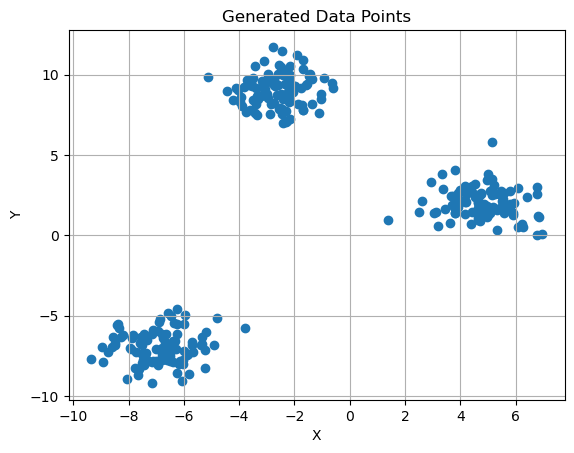

In [5]:
# generating data points
n_clusters = 3 # number of clusters to generate
cluster_test_data, _ = make_blobs(n_samples = n_clusters * 100, centers = n_clusters, random_state = 42) # seed for reproducibility

# plot
plt.scatter(cluster_test_data[:, 0], cluster_test_data[:, 1])
plt.title("Generated Data Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

In [6]:
# execute k_means
centroids, closest = k_means(cluster_test_data, n_clusters, 10)

Convergence found!


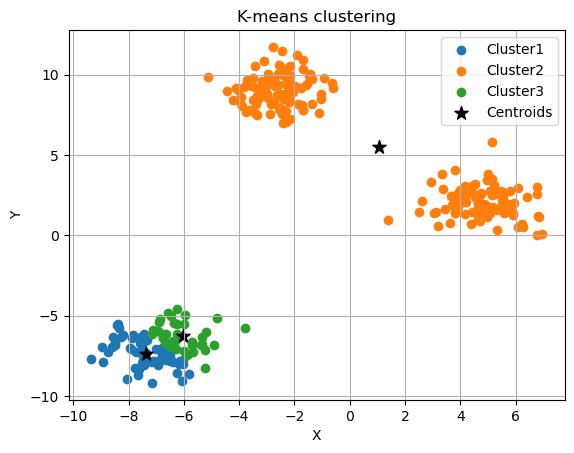

In [7]:
# group by cluster
clustered_points = {i: [] for i in range(n_clusters)}
for point in closest:
    clustered_points[point[0]].append(point[1])

# plot points
for i in range(n_clusters):
    cluster_data = np.array(clustered_points[i])
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label = "Cluster" + str(i + 1))

# plot centroids
centroids = np.array(centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], marker = "*", s = 100, color = "black", label = "Centroids")

plt.title("K-means clustering")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

---

**2)  Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.**

---

In [ ]:
# TODO

---

**3)  Run the algorithm on the data obtained from the dimensionality reduction.**

---

In [ ]:
# TODO

---

**4)  Implement **K-means++** from scratch and explain the differences with the results you got earlier.**

---

In [8]:
def k_means_plus_plus(data, n_clusters, max_iterations):
    # initiazation
    
    # create local spark session
    sc = SparkContext("local", "KMeans plus plus")

    # convert data in pyspark format
    data = sc.parallelize(data)

    # choose the first centroid randomly
    representatives = []
    representatives.append(data.takeSample(False, 1))
    
    for _ in range(1, n_clusters):
        # calculate distances from each point to the nearest centroid
        dists = data.map(lambda row: min([np.linalg.norm(row - r) for r in representatives]))

        # Choose the next centroid with probability proportional to the squared distance
        new = data.zip(dists).map(lambda x: (x[0], x[1])).max(lambda x: x[1])
        centroids.append(new[0])

    # the rest of the algorithm is the same as before
    for _ in range(max_iterations):

        closest = data.map(lambda row: (np.argmin([np.linalg.norm(row - r) for r in representatives]), (row, 1)))

        sums = closest.reduceByKey(lambda row1, row2: (row1[0] + row2[0], row1[1] + row2[1]))

        old_representatives = representatives
        representatives = sums.map(lambda cluster_sum: cluster_sum[1][0] / cluster_sum[1][1]).collect()
        
        if (np.equal(old_representatives, representatives).all()):
            print("Convergence found!")
            break

    clustered_points = []
    for point in closest.collect():
        # [cluster_id | coordinates]
        clustered_points.append((point[0], point[1][0]))

    # stop spark session
    sc.stop()

    return representatives, clustered_points

In [35]:
def k_means_plus_plus(data, n_clusters, max_iterations):
    # initiazation

    # choose the first centroid randomly
    representatives = [data[np.random.randint(data.shape[0])]]

    for _ in range(1, n_clusters):
        # calculate squared distances from each point to the nearest centroid
        dists = np.array([min([np.linalg.norm(d - r)**2 for r in representatives]) for d in data])

        # array of probability for each point to be taken
        # if a point is already a representative the probanility will be zero
        # and it will not be extracted again
        probs = dists / dists.sum()

        # random extraction
        new = data[np.random.choice(len(data), p = probs)]

        # add as new cluster representative
        representatives.append(new)
    
    # create local spark session
    sc = SparkContext.getOrCreate()

    # convert data in pyspark format
    data = sc.parallelize(data)
    
    # the rest of the algorithm is the same as before
    for _ in range(max_iterations):

        closest = data.map(lambda row: (np.argmin([np.linalg.norm(row - r) for r in representatives]), (row, 1)))

        sums = closest.reduceByKey(lambda row1, row2: (row1[0] + row2[0], row1[1] + row2[1]))

        old_representatives = representatives
        representatives = sums.map(lambda cluster_sum: cluster_sum[1][0] / cluster_sum[1][1]).collect()
        
        if (np.equal(old_representatives, representatives).all()):
            print("Convergence found!")
            break

    clustered_points = []
    for point in closest.collect():
        # [cluster_id | coordinates]
        clustered_points.append((point[0], point[1][0]))

    # stop spark session
    sc.stop()

    return representatives, clustered_points

In [36]:
# execute k_means
centroids, closest = k_means_plus_plus(cluster_test_data, n_clusters, 10)

Convergence found!


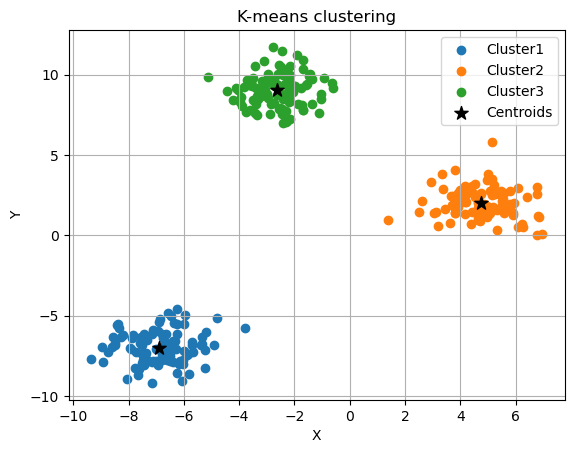

In [37]:
# group by cluster
clustered_points = {i: [] for i in range(n_clusters)}
for point in closest:
    clustered_points[point[0]].append(point[1])

# plot points
for i in range(n_clusters):
    cluster_data = np.array(clustered_points[i])
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label = "Cluster" + str(i + 1))

# plot centroids
centroids = np.array(centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], marker = "*", s = 100, color = "black", label = "Centroids")

plt.title("K-means clustering")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

---

**5)  Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?**

---

In [ ]:
# TODO

### 2.4 Analysing your results!

You are often encouraged to explain the main characteristics that your clusters have. The latter is called the *Characterizing Clusters* step. Thus, follow the next steps to do it:

1)  Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.

2)  Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.

3)  With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

4)  Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

5)  Interpret the results for each pivot table.

6)  Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.

---

**1)  Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.**

---

In [ ]:
# TODO

---

**2)  Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.**

---

In [ ]:
# TODO

---

**3)  With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.**

---

In [ ]:
# TODO

---

**4)  Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.**

---

In [ ]:
# TODO

---

**5)  Interpret the results for each pivot table.**

---

In [ ]:
# TODO

---

**6)  Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.**

---

In [ ]:
# TODO

## 3. Bonus Question

We remind you that we consider and grade the bonuses only if you complete the entire assignment.

[Density-based clustering](https://wires.onlinelibrary.wiley.com/doi/epdf/10.1002/widm.30) identifies clusters as regions in the data space with high point density that are separated from other clusters by regions of low point density. The data points in the separating regions of low point density are typically considered noise or outliers. Typical algorithms that fall into this category are [OPTICS](https://dl.acm.org/doi/pdf/10.1145/304181.304187) and [DBSCAN](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf).

1)  Ask ChatGPT (or any other LLM tool) to list three algorithms for Density-Based Clustering. Choose one and use it on the same dataset you used in 2.3. Analyze your results: how different are they from the centroid-based version?

__Note__: You can implement your algorithm from scratch or use the one implemented in the scikit-learn library; the choice is up to you!

In [ ]:
# TODO

## 4. Command Line Question

Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tool that you know to answer the following questions using the same dataset that you have been using so far:
  + What is the most-watched Netflix title?
  + Report the average time between subsequent clicks on Netflix.com
  + Provide the ID of the user that has spent the most time on Netflix
    
__Important note:__ You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a __screenshot__ of the <ins>output</ins> in the notebook for evaluation.  

In [ ]:
# TODO

## 5. Algorithmic Question 

Federico studies in a demanding university where he has to take a certain number $N$ of exams to graduate,  but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system. 

He was given an initial personal score of $S$ when he enrolled, which changes every time he takes an exam: now comes the crazy part.
He soon discovered that every of the $N$ exams he has to take is assigned a mark $p$. Once he has chosen an exam, his score becomes equal to the mark $p$, and at the same time, the scoring system changes:
+ If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity $S - p$.
+ If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity $p - S$.
  
So, for example, consider $S=8$ as the initial personal score. Federico must decide which exam he wants to take, being $[5,7,1]$ the marks list. If he takes the first one, being $5 < 8$ and $8 - 5 = 3$, the remaining list now becomes $[10,4]$, and his score is updated as $S = 5$.

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line,  and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get. 

a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on
because he wants to do paid counseling for other desperate students: in a *recursive* fashion, the helped helps the helpable.

b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university! 

c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. 
You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

Here are some input/output examples (the first value is the initial personal score, and the second line contains the list of marks): 

__Input 1__
```
8
5 7 1 
```

__Output 1__
```
11
```

__Input 2__
```
25
18 24 21 32 27
```

__Output 2__
```
44
```

__Input 3__
```
30
13 27 41 59 28 33 39 19 52 48 55 79
```

__Output 3__
```
205
```

**a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on
because he wants to do paid counseling for other desperate students: in a *recursive* fashion, the helped helps the helpable.**

---

The text of this first request seems to require we us to implement an algorithm that solves the problem using recursion. However, given the nature of the problem and the extensive number of possible permutations this approach is expected to be very inefficient in terms of computational time. While a "brute-force" approach would iterate trough every possible permutation without exploiting the fact that computations will be identical util a element of the permutation differ we decided to implement a smarter dynamic programming approach; this remembers previous computations, saving a noticeable amount of computational time.

---

In [54]:
def iterative_call(student_score, marks_list, solved_subproblems = {}):
    # base case, if the marks list has only one element we are forced to take it
    if len(marks_list) == 1:
        return marks_list[0]
    
    # if we have already solved this scenario we can take the result without
    # computing it again another time
    elif (student_score, marks_list) in solved_subproblems:
        return solved_subproblems[(student_score, marks_list)]
    
    # otherwise is a new scenario, we have to compute it by checking every possible path
    else:
        # we create a list of tuples, each tuple is the mark list if we chose to take a certain mark
        new_marks_lists = [tuple(mark + (student_score - marks_list[i]) for mark in marks_list[:i] + marks_list[i+1:]) for i in range(len(marks_list))]

        # we create a list of scores, that are the output of each new subproblem
        new_scores = [iterative_call(marks_list[i], new_marks_lists[i], solved_subproblems) for i in range(len(marks_list))]

        # we get the mark among all subproblems
        best_score = max(new_scores)
        
        # update solved subproblems dictionary
        solved_subproblems[(student_score, marks_list)] = best_score

        return best_score

def algorithmic_question_v1(input_string):
    input_list = input_string.split("\n")

    # get student score from input string
    original_student_score = int(input_list[0])

    # get marks list from input string
    original_marks_list = tuple(map(int, input_list[1].split(" ")))

    best_score = iterative_call(original_student_score, original_marks_list)

    print(best_score)

# tests as given by the text of the homework

input1 = "8\n5 7 1"
print("Test1:")
algorithmic_question_v1(input1)

input2 = "26\n18 24 21 32 27"
print("Test2:")
algorithmic_question_v1(input2)

input3 = "30\n13 27 41 59 28 33 39 19 52 48 55 79"
print("Test3:")
algorithmic_question_v1(input3)

Test1:
11
Test2:
44
Test3:
205


**b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!**

---

**Time complexity:**

We will analyze the computational time of this first algorithm in Big-O notation in the `average case scenario` to exploit the constant time get item cost of python dictionaries.

The algorithm explores all possible permutations of marks choices using recurive calls to avoid having to calculate again already seen scenarios. The iterative call functions is used `n` times in the first level of recursion and each of those calls lead to other `n - 1` calls in the second level of recursion and so on...

$n + n * (n - 1) + n * (n - 1) * (n - 2) + ... + n! = n! * \sum_{k = 1}^{n - 1} \frac{1}{k!} \in O(n!)$

The number of permutations is factorial and the number of iterative call is even higher, but in the same order. This means that even if our iterative call operation would have a constant time cost our algorithm would have a computational time of `O(n!)`. We now have to find the time complexity of a single execution of `iterative_call`. We will say that the current marks list has length `i`.

This function is composed of a condition that checks the length of the array (constant time), another condition that check if the scenario have already been seen (constant time thanks to our `average case scenario` assumption) and a cycle trough the current elements of marks list (`i` repetitions) that for every cycle create a new array (linear cost `O(i)`), an update operation on the new array (linear cost `O(i)`), the next iterative call (that will have length `i - 1`) and a max operation (constant time).

We can see that the value of `i` in the iterative call is not significative in the result of our analysis, as for the extreme case where `i = constant` the total cost of the algorithm will be:

$n! * constant \in O(n!)$

And in the opposite extreme where `i = n` the total cost will be:

$n! * n < n! * (n + 1) = (n + 1)! \in O((n + 1)!) = O(n!)$

The cost of the algorithm is therefore factorial, `O(n!)`. Such cost is unfeasable in real scenarios. By Stirling's approximation we can have a cleared idea of how bad a factorial computational cost is:

$n! \approx \sqrt{2\pi n}\left(\frac{n}{e}\right)^n$

That is `O(n^n)`. The examples executed above are small enough to be computed in a few seconds, but even only doubling the size of the input of test3 (that means input = $12 * 2 = 24$) shows a great slowdown as even half an hour hasn't been enough to complete the computation.

---

**c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. 
You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)**

---

This new algorithm is based on the following observations on every permutation of the marks that yields the best output:

* They are an alternation of values below and above the median. The order in which we take those values is not significant, the only thing that matters is the alternation between above and below the median.
* They start with a value below the median and end with one above.
* The only time there are two successive elements are from the same side is when the number of marks is uneven.

Furthermore, we can split a permutation with this properties into couples and observe that every couple push the value of every mark in the list forward by a factor equal to the difference between the two values. There is also a "starting value" that is the median itself when the number of marks is uneven and the starting score of the student when the number of marks is even (this means that the starting value of the student is not significative if the number of marks is odd). Since as we said before the order is not significant we can take them in any order and see the final results as the sum of all the values above the median minus all the values below.

Therefore to find the highest output value without visiting and executing all the permutations we can think of an algorithm that does the following: finds the median, divide the marks list in two sets, one less or equal the median and the other greater than the median. Once splitted into two groups we can just sum all the values above the median and subtract the values below.

---

In [68]:
def algorithmic_question_v2(input_string):
    input_list = input_string.split("\n")

    # get student score from input string
    student_score = int(input_list[0])

    # get marks list from input string
    marks_list = list(map(int, input_list[1].split(" ")))

    # sort values
    marks_list.sort()

    # treat even/odd case
    result = 0 if len(marks_list) % 2 == 1 else student_score

    # sum value above median and substract values below median
    result += sum(marks_list[len(marks_list) // 2 :]) - sum(marks_list[: len(marks_list) // 2])
    
    print(result)

# tests as given by the text of the homework

input1 = "8\n5 7 1"
print("Test1:")
algorithmic_question_v2(input1)

input2 = "25\n18 24 21 32 27"
print("Test2:")
algorithmic_question_v2(input2)

input3 = "30\n13 27 41 59 28 33 39 19 52 48 55 79"
print("Test3:")
algorithmic_question_v2(input3);

Test1:
11
Test2:
44
Test3:
205


---

**Time complexity:**

We will analyze the computational time of the algorithm in Big-O notation in the `worst case scenario`.

We can see the algorithm as divided in three principal components with their cost proportional to the size number of marks in the input, that we will call `n`.

* The first thing the algorithm does is read all the input, for which it takes time proportional to the size of the input, `O(n)`.
* After reading all the input the marks list is sorted to find the median. Using any of the worst case scenario optimal sorting algorithm will take us `O(n * logn)` time.
* Finally we have to sum and substract every value of the mark list according to its position in the sorted list. Since the sum/substraction operation is constant and its executed exactly once for every element in the marks list this component of the algorithm has linear cost `O(n)`.

The cost of the algorithm in the worst case scenario is therefore `O(n * logn)` as the sorting operation is the heaviest component of the algorithm. We can observe that the results can be even better if re-design our algorithm focussing on performances for the `average case scenario`:

Since we do not really need the sorting of the list but only to find the median and divide between above and below it we can execute a `quickselect` algorithm instead of a sorting and then divide into two sets by confronting each element with the median. The quickselect, as well as the subsequent division in subsets has a average computational time of `O(n)`, rendering the algorithm with linear cost `O(n)` in the average case scenario.

We decided to not use this design in our algorithm as the worst case scenario for it is given by the worst case of quickselect and is `O(n^2)`.

---

**d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!**

---

We asked Chat GPT 3.5 to write an algorithm using the following prompt:

```
Resolve the problem proposed by the following text with a python algorithm, giving particular attention to code correctness and to find a strategy that minize its computational cost:
[The proposed algorithm text, including the examples]
```

And the received output is:

```
This problem can be approached through a recursive algorithm that explores all possibilities. Here's a Python solution that implements this approach:

def highest_score_possible(score, marks):
    if not marks:  # Base case: if there are no exams left, return the current score
        return score

    max_score = score  # Initialize the maximum score with the current score
    
    for i in range(len(marks)):
        new_score = marks[i]  # Set new score if Federico takes this exam

        # Determine the new list of marks based on the exam chosen
        new_marks = marks[:i] + marks[i+1:]
        for j in range(len(new_marks)):
            if new_score > score:  # For hard exams
                new_marks[j] -= new_score - score
            elif new_score < score:  # For easy exams
                new_marks[j] += score - new_score

        # Recursive call to find the maximum score
        max_score = max(max_score, highest_score_possible(new_score, new_marks))

    return max_score

# Example usage
initial_score = 8
marks_list = [5, 7, 1]
result = highest_score_possible(initial_score, marks_list)
print(result)


This algorithm works through recursion, exploring every possible choice Federico can make at each step (taking a different exam) and calculating the maximum score achievable.

However, the code can become inefficient for larger inputs due to its recursive nature. The time complexity of this solution is exponential, specifically O(2^N), where N is the number of exams Federico has to take. As the number of exams increases, the number of recursive calls and computations grows exponentially, making it slow for larger inputs.

To optimize this algorithm, we can utilize dynamic programming to store intermediate results and avoid redundant calculations. This can significantly improve the efficiency of the solution by reducing unnecessary recursive calls.

Let me know if you'd like to explore this optimization further!
```

This result is particularly bad, as it's wrong in the results and tries to mimick a recursive resolution of the problem, that as we have seen has a very bad computational time. However the LLM fails to grasp the resolution algorithm itself, as it consider the current student score of an intermediate operation as a possible value for the output. We point that out to the LLM:

```
Don't initialize the maximum with the current score
```

And the response is:

```
You're right! We don't need to initialize the maximum score with the current score. Here's an updated version of the code:

def highest_score_possible(score, marks):
    if not marks:  # Base case: if there are no exams left, return the current score
        return score

    max_score = float('-inf')  # Initialize maximum score as negative infinity
    
    for i in range(len(marks)):
        new_score = marks[i]  # Set new score if Federico takes this exam

        # Determine the new list of marks based on the exam chosen
        new_marks = marks[:i] + marks[i+1:]
        for j in range(len(new_marks)):
            if new_score > score:  # For hard exams
                new_marks[j] -= new_score - score
            elif new_score < score:  # For easy exams
                new_marks[j] += score - new_score

        # Recursive call to find the maximum score
        max_score = max(max_score, highest_score_possible(new_score, new_marks))

    return max_score

# Example usage
initial_score = 8
marks_list = [5, 7, 1]
result = highest_score_possible(initial_score, marks_list)
print(result)

This change avoids initializing max_score with the current score and uses float('-inf') to ensure the correct initialization of the maximum score.
```

Now the algorithm is correct, but the solution is brute-force and doesn't uses a dynamic-programming approach, increasing further the computational time of the algorithm, that would however still be in the big O notation of 'O(n!)' as it explores all possible iterative calls are 'O(n!)' in number and 'O(n)' in cost. Since the request asked us to study an optimized implementation made by chatGPT we try to obtain it by explaining our observations to the LLM:

```
Create an optimized version of this algorithm by exploiting those observations made on the optimal results:
[Paragraph on the observations written in point c of this exercise]
```

And the received output is:

```
Absolutely, leveraging these observations allows for a more direct and optimized approach. We can use the median to split the marks into two sets: one with marks above the median and another with marks below or equal to the median. Then, we can perform calculations on these sets to determine the highest possible score Federico can achieve.

Here's an implementation based on this approach:

def highest_score_possible_optimized(score, marks):
    marks.sort()  # Sort the marks
    median_index = len(marks) // 2
    median = marks[median_index] if len(marks) % 2 != 0 else (marks[median_index - 1] + marks[median_index]) // 2

    marks_below_median = marks[:median_index]
    marks_above_median = marks[median_index + (1 if len(marks) % 2 != 0 else 0):]

    # Sum all values above the median and subtract the values below
    return sum(marks_above_median) - sum(marks_below_median)

# Example usage
initial_score = 8
marks_list = [5, 7, 1]
result = highest_score_possible_optimized(initial_score, marks_list)
print(result)

This optimized version sorts the marks, identifies the median, and then splits the marks into two sets: one with values above the median and another with values below or equal to the median. Finally, it calculates the highest possible score by summing the values above the median and subtracting the values below or equal to the median. This approach doesn't require exploring all permutations and directly computes the highest achievable score based on the properties observed.
```

While the algorithm is not entirely correct as it does not take into account the starting value of the student and we could challenge chatGPT further to adjust it, the computational cost is the same as it would be for the correct solution and is the same as what we have described above, given that chatGPT just transposed our observations into code.

---